In [1]:
import warnings
warnings.filterwarnings("ignore")
from textrank4zh import TextRank4Keyword,TextRank4Sentence
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import jieba.analyse
import os
import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# GET_KEYWORDS
def get_keywords(x):
    if pd.isna(x):
        return np.nan
    else:
        # TEXTRANK TOP 10
        tr4w = TextRank4Keyword(stop_words_file='./base_data/stopword.data')
        tr4w.train(text=x, speech_tag_filter=True, lower=True, window=2)
        keywords_textrank = tr4w.get_keywords(10, word_min_len=2)
        # Top_10 TF_IDF words
        keywords_tfidf = jieba.analyse.extract_tags(x)[:10]
        # Intersection
        result_ = list(set(keywords_textrank).intersection(set(keywords_tfidf)))
        return result_

In [3]:
# READ_DATA
df = pd.read_csv('./raw_data/datawithcor.csv')
# DROP NAN
df = df[df.Fatality_Rate.notna()]
df = df[df.Narrative.notna()]
df = df.sample(n=300, frac=None, replace=False, weights=None, random_state=None, axis=None)

In [4]:
# KEYWORDS EXTRACTION
df['key_words'] = df.Narrative.apply(lambda x: get_keywords(x))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/pj/mrvgnnps0n92zyj8t94f613r0000gn/T/jieba.cache
Loading model cost 0.626 seconds.
Prefix dict has been built successfully.


In [5]:
# SET X and Y
x_columns = ['year', 'Type', 'Operator', 'Lat', 'Long', 'key_words']
y_columns = 'Fatality_Rate'

In [6]:
# PRE_TRAIN
# Lat, Long ABS
df.Lat = df.Lat.abs()
df.Long = df.Long.abs()

In [7]:
# Order Map
type_dict = {'Caproni': 0, 'Felixstowe': 1}
operator_dict = {'Caproni': 0, 'Royal Air Force - RAF': 1}
df.Type = df.Type.map(type_dict)
df.Operator = df.Operator.map(operator_dict)

In [8]:
# TF_IDF
# 'Pre_Train, join null intro words
df['key_words_new'] = df.key_words.apply(lambda x: ' '.join(x))
# tfidf
tf_train = TfidfVectorizer()
tf_result = tf_train.fit_transform(df.key_words_new.tolist())

In [9]:

if os.path.exists('./base_data/vocabulary.json'):
    os.remove('./base_data/vocabulary.json')
if os.path.exists('./base_data/idfs.npy'):
    os.remove('./base_data/idfs.npy')
f1 = open('./base_data/vocabulary.json', 'wb')
file = tf_train.vocabulary_
pickle.dump(file,f1)
f1.close()
idfs = tf_train.idf_
np.save('./base_data/idfs.npy',idfs)
# 
# idfs = np.load('./base_data/idfs_con.npy')
# x_list = [[contents_[i],add_info[i],x_list_1[i],x_list_2[i]] for i in range(len(x_list_1))]
# vocabulary_import = pickle.load(open('./base_data/vocabulary_con.json','rb'))
# tf_train = MyVectorizer(vocabulary = vocabulary_import)
# tf_train._tfidf._idf_diag = sp.spdiags(idfs,
#                                      diags = 0,
#                                      m = len(idfs),
#                                      n = len(idfs))

In [10]:
# 'Merge TD_IDF'
a = df[x_columns[:-1]]
all_feature = np.hstack((a,  tf_result.toarray()))

In [11]:
# Model Building
# Set split
x_train, x_test, y_train, y_test = train_test_split(all_feature, df[y_columns],  test_size=0.3, random_state=0)

In [12]:
# lgb
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100)
gbm.fit(x_train, y_train)
y_pre = gbm.predict(x_test)
print('mse: ', mean_squared_error(y_test, y_pre))

mse:  0.1876348024735526


In [13]:
import xgboost as xgb
#We load our model from .dat file
bat = pickle.load(open("pima.pickle.dat", "rb"))
bat.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=nan, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0.8, reg_lambda=0.5, scale_pos_weight=1, seed=4396,
             silent=None, subsample=0.8, verbosity=1)

In [14]:
mean_squared_error(bat.predict(x_test),y_test)

0.1781379995319942

In [15]:
print("The mean of test data is : "+str(np.mean(y_test)))
print("The maximum of test data is : "+str(np.max(y_test)))
print("The minimum of test data is : "+str(np.min(y_test)))
print("The mean of predicted test data is : "+str(np.mean(bat.predict(x_test))))
print("The maximum of predicted test data is : "+str(np.max(bat.predict(x_test))))
print("The minimum of predicted test data is : "+str(np.min(bat.predict(x_test))))
print("The residual mean squared error of predicted value is : "+str(mean_squared_error(bat.predict(x_test),y_test)))

The mean of test data is : 0.3920703633777778
The maximum of test data is : 1.0
The minimum of test data is : 0.0
The mean of predicted test data is : 0.38590822
The maximum of predicted test data is : 0.8590774
The minimum of predicted test data is : 0.047915213
The residual mean squared error of predicted value is : 0.1781379995319942


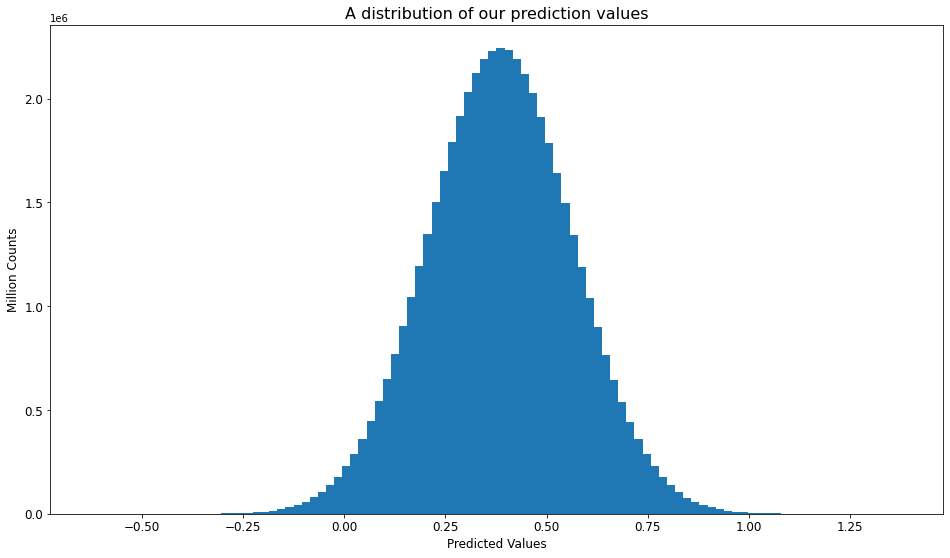

In [16]:
def demo1():
    mu ,sigma = np.mean(bat.predict(x_test)), mean_squared_error(bat.predict(x_test),y_test)
    sampleNo = 50000000
    np.random.seed(0)
    s = np.random.normal(mu, sigma, sampleNo)
    plt.figure(figsize = (16,9))
    plt.hist(s, bins=100)
    plt.title("A distribution of our prediction values",fontsize = 16)
    plt.xlabel('Predicted Values',fontsize = 12)
    plt.ylabel('Million Counts',fontsize =12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.savefig('Demo.jpg')
demo1()

In [17]:
from collections import defaultdict
k = defaultdict(int)
for i in df['key_words']:
    for c in i:
        k[c]+=1
df['key_words']

6687                            [couldn, aircraft, rotate]
4305                             [hand, feet, pilot, seat]
2971                                                    []
653                                 [area, flight, clouds]
4174     [aircraft, crashed, check, captain, company, p...
                               ...                        
11033                                           [altitude]
12787           [turn, airplane, registered, flight, left]
7930                                    [runway, aircraft]
4503                               [stalled, crashed, sea]
908                                       [part, aircraft]
Name: key_words, Length: 300, dtype: object

In [18]:
import operator
# Rank the keywords by frequency
sorted_x = sorted(k.items(),key = operator.itemgetter(1),reverse = True)

[0.20925608, 0.099327885, 0.09360592, 0.08554081, 0.074449435, 0.07326494, 0.067595094, 0.05789403, 0.048634313, 0.048001815, 0.04359067]
['212', '91', '328', '152', '284', '280', '382', '0', '93', '3', '167']


Text(0.5, 1.0, 'Importance Score of Factors')

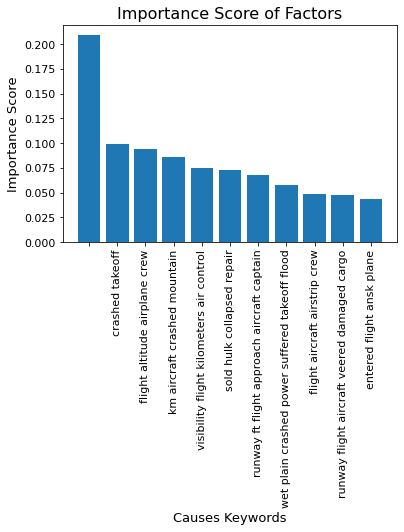

In [19]:
l = []
for i,z in enumerate(bat.feature_importances_):
    l.append((i,z))
sorted_l = sorted(l,key = operator.itemgetter(1),reverse = True)
sorted_l = sorted_l[:11]
xlbl =  [str(i[0]) for i in sorted_l]
sorted_l = [i[1] for i in sorted_l]
print(sorted_l) 
print(xlbl)
k = set()
for i in df['key_words_new']:
    k.add(i)
k = list(k)
c = [k[x] for x,i in enumerate(xlbl)]
c
plt.bar(c,sorted_l)
plt.xlabel('Causes Keywords',fontsize= 13)
plt.ylabel('Importance Score',fontsize = 13)
plt.xticks(rotation = 90, fontsize = 11)
plt.yticks(fontsize = 11)
#plt.legend(fontsize = 19)
plt.title('Importance Score of Factors',fontsize = 16)

Text(0.5, 1.0, 'XGB Predicted Values')

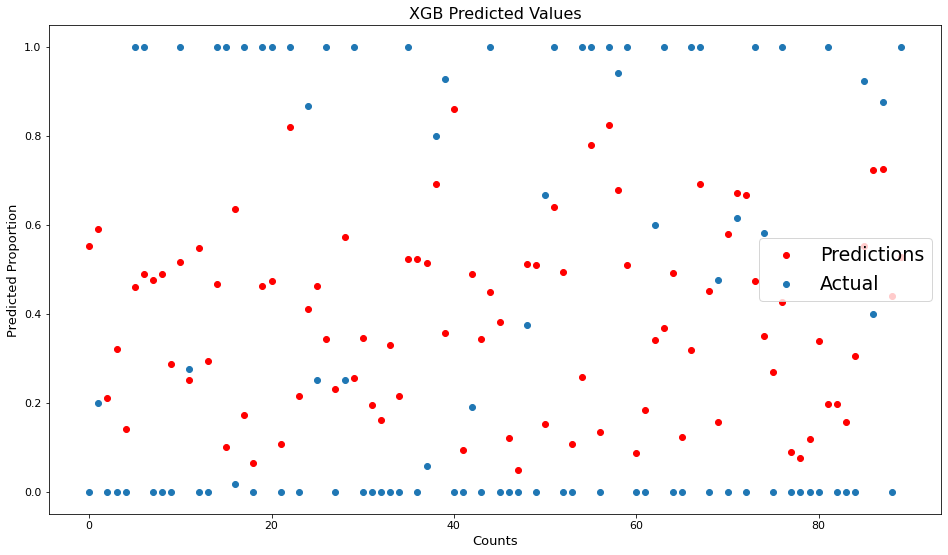

In [20]:
plt.figure(figsize = (16,9))
plt.scatter([i for i in range(len(y_test))],bat.predict(x_test),color = 'red',label = 'Predictions')
plt.scatter([i for i in range(len(y_test))],y_test,label = 'Actual')
plt.xlabel('Counts',fontsize= 13)
plt.ylabel('Predicted Proportion',fontsize = 13)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.legend(fontsize = 19)
plt.title('XGB Predicted Values',fontsize = 16)